In [8]:
# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader

# Pyro imports - the star of our show!
import pyro
import pyro.nn as pyro_nn
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.nn import PyroModule, PyroSample

# For statistical analysis
from scipy import stats
import seaborn as sns

# Set up plotting style (matching your notebook)
plt.style.use('default')  # You can change this to match your style
sns.set_palette("husl")

from base_lines.base_lines import MCDropoutNN

import time

from UQ import NN_UQ

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [3]:
def complex_function(x):
    return torch.cos(20*torch.pi*torch.abs(x)**(1.4)) + 0.5*torch.cos(12*torch.pi*torch.abs(x)**(1.6))

In [4]:
torch.manual_seed(0)
x_train_no_noise = torch.cat([torch.linspace(-1, -0.2, 400, device=device),
    torch.linspace(0.2, 1, 400, device=device)
]).unsqueeze(1)
y_train_no_noise = complex_function(x_train_no_noise.squeeze())

x_train_noise = torch.linspace(-0.2, 0.2, 200, device=device).unsqueeze(1)
y_train_noise = complex_function(x_train_noise.squeeze()) #+ 0.01 * torch.randn(x_train_noise.shape[0], device=device)

x_train = torch.cat([x_train_no_noise, x_train_noise], dim=0)
y_train = torch.cat([y_train_no_noise, y_train_noise], dim=0)

x_test = torch.linspace(-1.2, 1.2, 2000, device=device).unsqueeze(1)
y_test_true = complex_function(x_test.squeeze())


In [5]:

# Create model
model = MCDropoutNN(
    input_size=1, 
    hidden_size=366,  
    output_size=1, 
    num_layers=6,
    dropout_rate=0.1,
    n_dropout_layers=1  # Apply dropout only in the last k layers
).to(device)

# Standard training (much more stable!)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
criterion = nn.MSELoss()


Using dropout in layers: [4]


In [6]:
# Training
losses = []
batch_size = 500
num_epochs = 800

dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [7]:
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    if epoch % 200 == 0:
        elapsed = time.time() - start_time
        print(f"Epoch {epoch:4d}: Loss = {avg_loss:.6f} [{elapsed:.1f}s]")

total_time = time.time() - start_time


print(f"Training completed in {total_time:.1f} seconds")

/work/Sebas/miniconda3/envs/MMNN/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch    0: Loss = 1.033968 [0.2s]
Epoch  200: Loss = 0.534328 [2.0s]
Epoch  400: Loss = 0.525666 [3.9s]
Epoch  600: Loss = 0.520539 [6.1s]
Training completed in 8.2 seconds


In [9]:
model_uq = NN_UQ(model)

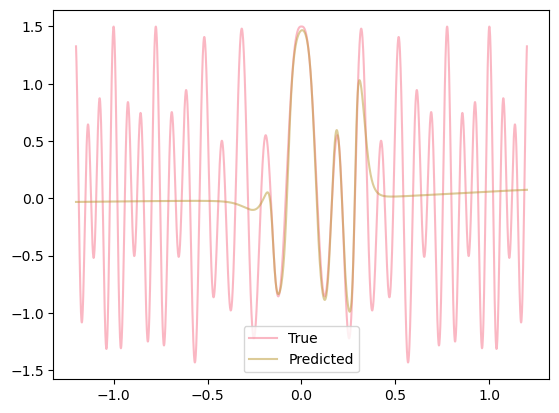

In [10]:
y_pred = model_uq.predict(x_test)
plt.plot(x_test.cpu(), y_test_true.cpu(), label='True', alpha=0.5)
plt.plot(x_test.cpu(), y_pred, label='Predicted', alpha=0.5)
plt.legend()
plt.show()

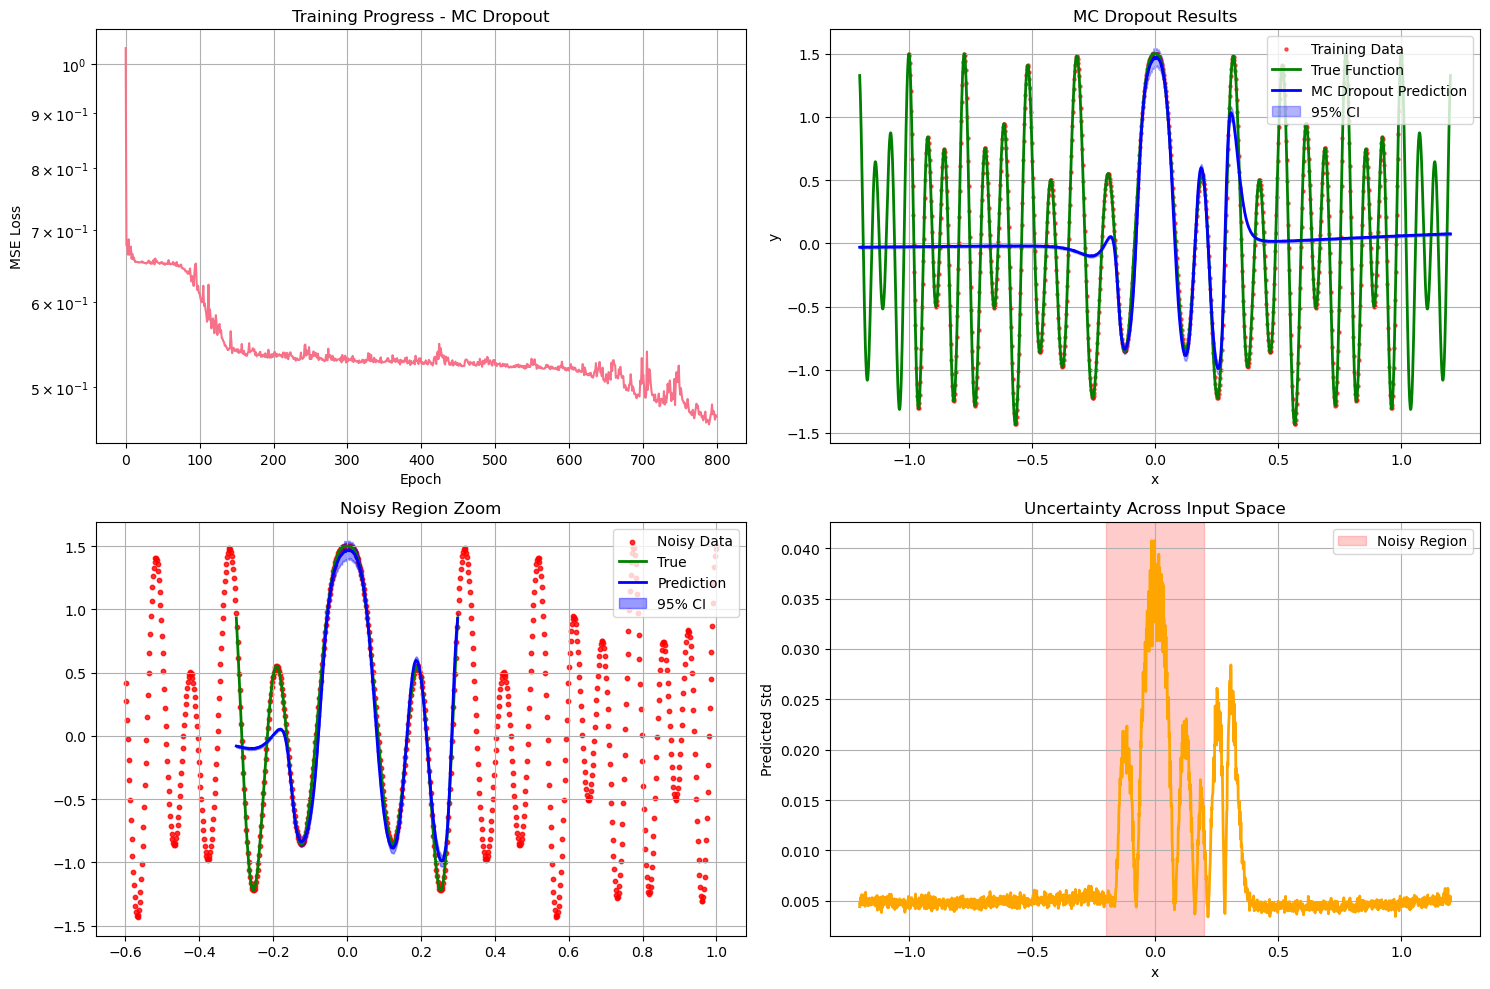

TypeError: 'int' object is not callable

In [12]:

# Generate predictions with uncertainty


pred_mean, pred_std, lower, upper = model_uq.compute_uncertainty(x_test, n_samples=100)


# Move to CPU for plotting
x_test_cpu = x_test.cpu()
y_test_true_cpu = y_test_true.cpu()
pred_mean_cpu = pred_mean
pred_std_cpu = pred_std
x_train_cpu = x_train.cpu()
y_train_cpu = y_train.cpu()

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training progress
axes[0,0].plot(losses)
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('MSE Loss')
axes[0,0].set_title('Training Progress - MC Dropout')
axes[0,0].grid(True)
axes[0,0].set_yscale('log')

# Full predictions
axes[0,1].scatter(x_train_cpu, y_train_cpu, alpha=0.6, s=5, color='red', label='Training Data')
axes[0,1].plot(x_test_cpu, y_test_true_cpu, 'g-', linewidth=2, label='True Function')
axes[0,1].plot(x_test_cpu, pred_mean_cpu, 'blue', linewidth=2, label='MC Dropout Prediction')
axes[0,1].fill_between(x_test_cpu.squeeze(), 
                      pred_mean_cpu - 1.96*pred_std_cpu, 
                      pred_mean_cpu + 1.96*pred_std_cpu,
                      alpha=0.3, color='blue', label='95% CI')

axes[0,1].set_xlabel('x')
axes[0,1].set_ylabel('y')
axes[0,1].set_title('MC Dropout Results')
axes[0,1].legend()
axes[0,1].grid(True)

# Zoom on noisy region
mask = (x_test_cpu.squeeze() >= -0.3) & (x_test_cpu.squeeze() <= 0.3)
axes[1,0].scatter(x_train_cpu[200:], y_train_cpu[200:], alpha=0.8, s=10, color='red', label='Noisy Data')
axes[1,0].plot(x_test_cpu[mask], y_test_true_cpu[mask], 'g-', linewidth=2, label='True')
axes[1,0].plot(x_test_cpu[mask], pred_mean_cpu[mask], 'blue', linewidth=2, label='Prediction')
axes[1,0].fill_between(x_test_cpu[mask].squeeze(), 
                      (pred_mean_cpu - 1.96*pred_std_cpu)[mask], 
                      (pred_mean_cpu + 1.96*pred_std_cpu)[mask],
                      alpha=0.4, color='blue', label='95% CI')
axes[1,0].set_title('Noisy Region Zoom')
axes[1,0].legend()
axes[1,0].grid(True)

# Uncertainty plot
axes[1,1].plot(x_test_cpu, pred_std_cpu, 'orange', linewidth=2)
axes[1,1].axvspan(-0.2, 0.2, alpha=0.2, color='red', label='Noisy Region')
axes[1,1].set_xlabel('x')
axes[1,1].set_ylabel('Predicted Std')
axes[1,1].set_title('Uncertainty Across Input Space')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Performance metrics
mse = F.mse_loss(pred_mean, y_test_true).item()
mae = F.l1_loss(pred_mean, y_test_true).item()


print(f"   MSE: {mse:.6f}")
print(f"   MAE: {mae:.6f}")
print(f"   Training Loss: {losses[-1]:.6f}")


In [15]:
# bayes_mlp_pyro.py
import math
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal

from pyro.optim import ClippedAdam
import matplotlib.pyplot as plt
from tqdm import trange

# reproducibility
pyro.clear_param_store()
torch.manual_seed(0)

# --- synthetic dataset: y = sin(3*x) + noise
def make_data(n=200):
    x = torch.linspace(-1.0, 1.0, n).unsqueeze(-1)
    # y = torch.sin(3.0 * x).squeeze(-1) + 0.3 * torch.randn(n)
    y = (torch.cos(20*torch.pi*torch.abs(x)**(1.4)) + 0.5*torch.cos(12*torch.pi*torch.abs(x)**(1.6))).squeeze(-1) + 0.1 * torch.randn(n)
    return x, y

X_train, y_train = make_data(1000)
X_test = torch.linspace(-1.5, 1.5, 200).unsqueeze(-1)

# --- Bayesian MLP as a PyroModule
class BayesianMLP(PyroModule):
    def __init__(self, in_dim=1, hidden=100, out_dim=1):
        super().__init__()
        # define layers as PyroModule so we can attach priors
        self.fc1 = PyroModule[nn.Linear](in_dim, hidden)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden, in_dim]).to_event(2))
        self.fc1.bias   = PyroSample(dist.Normal(0., 1.).expand([hidden]).to_event(1))
        
        self.fc2 = PyroModule[nn.Linear](hidden, hidden)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([hidden, hidden]).to_event(2))
        self.fc2.bias   = PyroSample(dist.Normal(0., 1.).expand([hidden]).to_event(1))
        
        self.out = PyroModule[nn.Linear](hidden, out_dim)
        self.out.weight = PyroSample(dist.Normal(0., 1.).expand([out_dim, hidden]).to_event(2))
        self.out.bias   = PyroSample(dist.Normal(0., 1.).expand([out_dim]).to_event(1))

        self.activation = nn.ReLU()

    def forward(self, x, y=None):
        # x: [batch, in_dim]
        z = self.activation(self.fc1(x))
        z = self.activation(self.fc2(z))
        mean = self.out(z).squeeze(-1)  # [batch]
        # observation noise (learnable)
        sigma = pyro.sample("obs_sigma", dist.LogNormal(-1.0, 0.5))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

# instantiate model
model = BayesianMLP(in_dim=1, hidden=250, out_dim=1)

# --- guide: AutoDiagonalNormal (mean-field Gaussian for all PyroSample sites)
guide = AutoDiagonalNormal(model)

# optimizer and SVI
optim = ClippedAdam({"lr": 1e-3})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

# convert training data to float tensors
X = X_train.float()
Y = y_train.float()

# --- training loop
n_steps = 10000
log_interval = 250
losses = []
for step in trange(n_steps):
    loss = svi.step(X, Y)  # step returns negative elbo (loss)
    losses.append(loss)
    if (step + 1) % log_interval == 0:
        print(f"Step {step+1} / {n_steps}, loss = {loss:.2f}")

# --- posterior predictive sampling
# draw samples from guide, run predictive
predictive = Predictive(model, guide=guide, num_samples=200,
                        return_sites=("obs", "_RETURN"))
# Note: model expects both x and y (y optional); Predictive will call forward with x
post_pred = predictive(X_test.float())

# post_pred["obs"] shape: [num_samples, batch_size]
obs_samples = post_pred["obs"].detach().cpu()  # Tensor

# compute mean and 90% credible intervals
pred_mean = obs_samples.mean(0)
lower = torch.quantile(obs_samples, 0.05, dim=0)
upper = torch.quantile(obs_samples, 0.95, dim=0)

# --- plotting
plt.figure(figsize=(8, 5))
# training data
plt.scatter(X_train.squeeze().numpy(), y_train.numpy(), s=10, alpha=0.6, label="train data")
# predictive mean
plt.plot(X_test.squeeze().numpy(), pred_mean.numpy(), label="predictive mean", linewidth=2)
# credible interval
plt.fill_between(X_test.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.3, label="90% CI")
plt.legend()
plt.title("Bayesian MLP regression (Pyro)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# optional: plot ELBO curve
plt.figure(figsize=(6,3))
plt.plot(torch.tensor(losses).numpy())
plt.yscale("log")
plt.title("SVI loss (negative ELBO)")
plt.xlabel("step")
plt.show()


  3%|▎         | 268/10000 [00:02<01:38, 99.01it/s]

Step 250 / 10000, loss = 146958.68


  5%|▌         | 518/10000 [00:05<01:35, 98.94it/s]

Step 500 / 10000, loss = 112276.33


  8%|▊         | 767/10000 [00:07<01:33, 98.46it/s]


Step 750 / 10000, loss = 101213.49


KeyboardInterrupt: 